In [1]:
# import the required packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import regex as re
import datetime
import scipy.stats as stats
import squarify as sq
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

## 1. HR Analytics

### 1.1 Load and Explore the data

In [2]:
hr = pd.read_csv(".\data\hr_data.csv")
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [3]:
hr.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [4]:
hr[hr.education.isnull()]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
21,33332,Operations,region_15,NaN,m,sourcing,1,41,4.0,11,0,0,57,0
32,35465,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.0,2,0,0,48,0
43,17423,Sales & Marketing,region_2,NaN,m,other,3,24,2.0,2,0,0,48,0
82,66013,Sales & Marketing,region_2,NaN,m,sourcing,2,25,3.0,2,0,0,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54692,14821,Sales & Marketing,region_2,NaN,f,sourcing,1,35,3.0,7,0,0,53,0
54717,7684,Analytics,region_2,NaN,m,sourcing,1,32,3.0,4,0,0,86,0
54729,1797,HR,region_2,NaN,f,other,1,28,3.0,2,0,0,53,0
54742,38935,Sales & Marketing,region_31,NaN,m,other,1,28,4.0,3,0,0,47,0


In [5]:
print(len(hr[hr.previous_year_rating.isnull() & hr.length_of_service == 1]))

4124


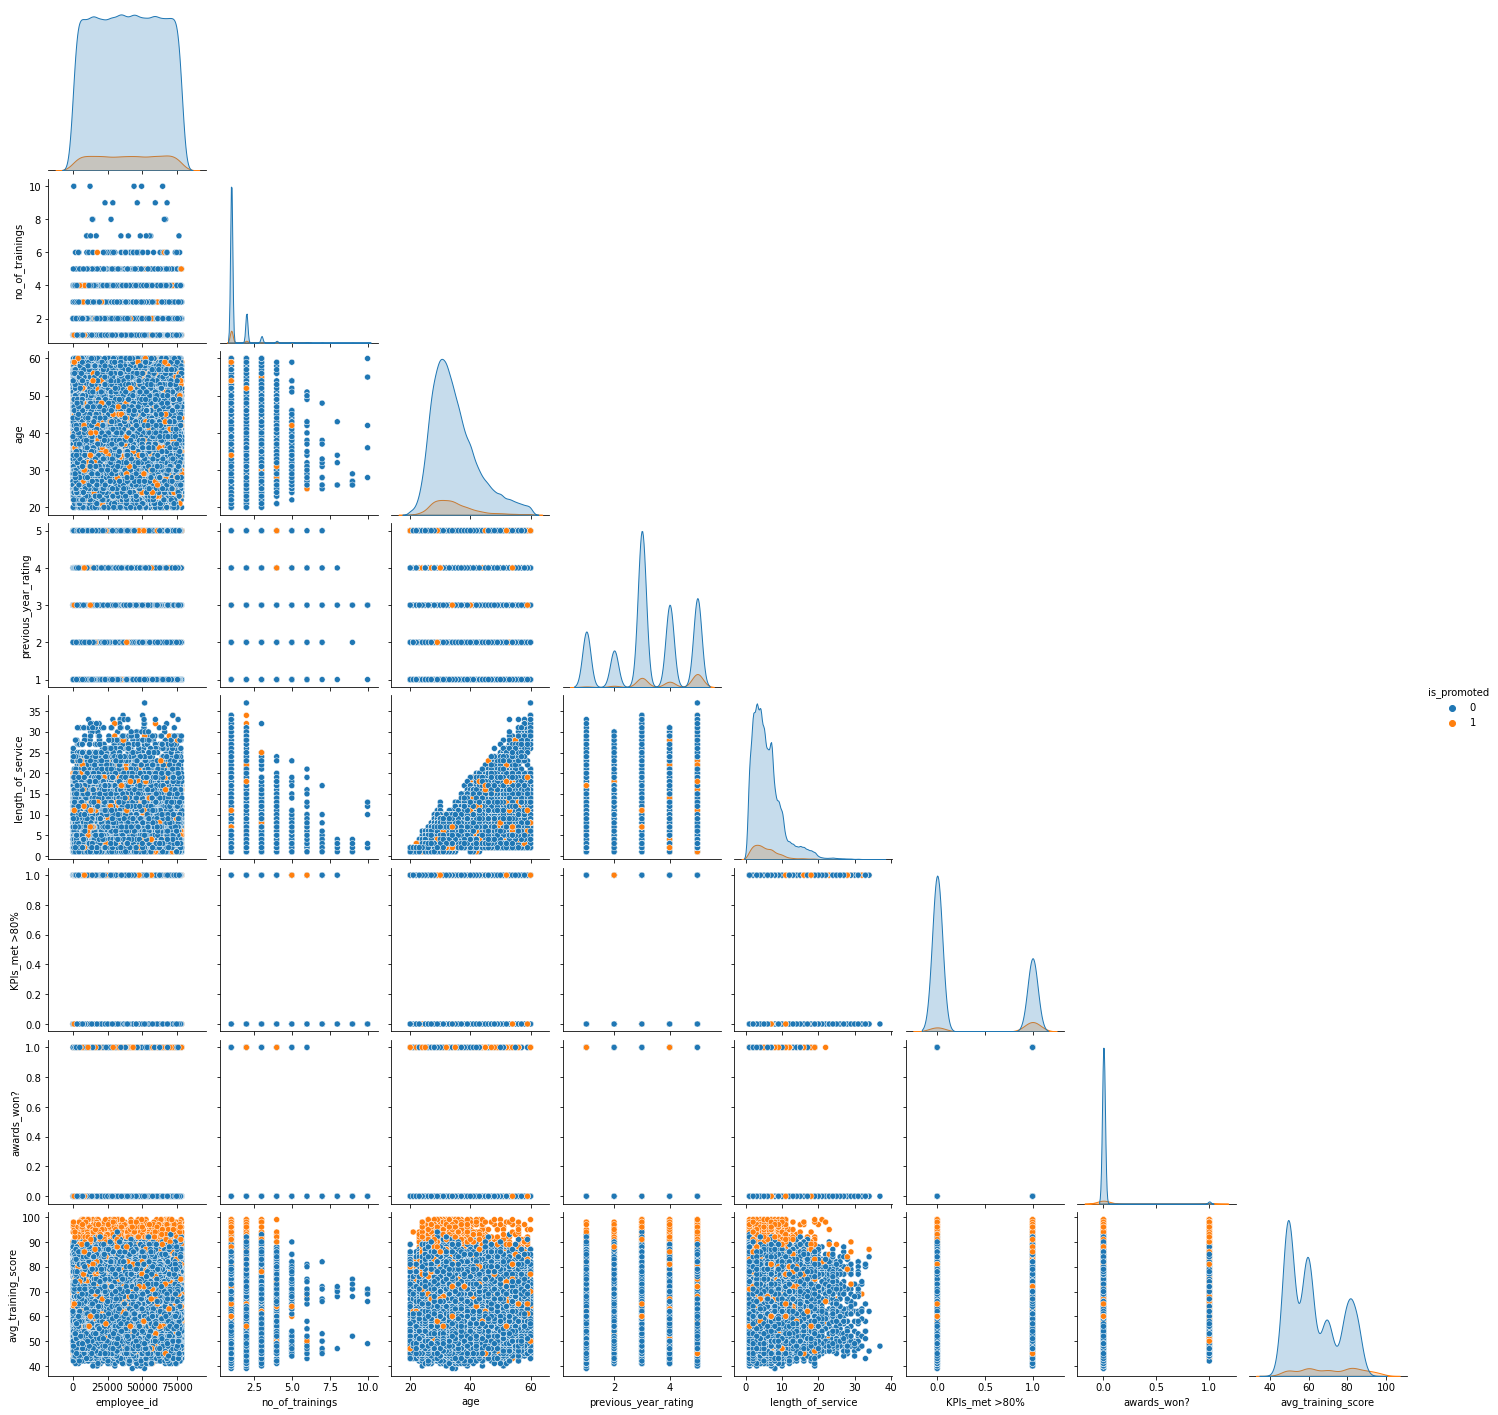

In [6]:
sns.pairplot(hr, hue = "is_promoted", corner = True)
plt.show()

### 1.2 Cleanse and Transform the data

In [7]:
hr["education"].fillna("Missing", inplace = True)

In [8]:
hr["previous_year_rating"].fillna(0, inplace = True)

In [9]:
hr.drop(columns = "employee_id",inplace = True)

In [10]:
def tts(df,target):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop(target, axis=1), df[target], test_size=0.3, random_state = 1)
    return X_train, X_test, y_train, y_test

xtra,xtes,ytra,ytes = tts(hr,"is_promoted")

In [11]:
def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def encode(train, test, variable, mapping):
    train[variable] = train[variable].map(mapping)
    test[variable] = test[variable].map(mapping)

In [12]:
from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [13]:
edu_map = {"Master's & above": 3, 
           "Bachelor's": 2, 
           'Missing': 0, 
           'Below Secondary': 1}

encode(xtra,xtes,"education",edu_map)

In [14]:
ohe.fit(xtra)
xtra  = ohe.transform(xtra)
xtes = ohe.transform(xtes)

In [15]:
xtra.head(5)

,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_HR,department_Sales & Marketing,...,region_region_21,region_region_6,region_region_19,region_region_10,region_region_20,region_region_27,region_region_5,gender_f,recruitment_channel_other,recruitment_channel_sourcing
51189,2,1,29,0.0,1,1,0,52,1,0,...,0,0,0,0,0,0,0,1,1,0
35949,3,1,44,5.0,11,1,0,47,0,1,...,0,0,0,0,0,0,0,1,0,1
36385,0,1,30,3.0,3,0,0,50,0,1,...,0,0,0,0,0,0,0,0,0,1
43913,3,1,44,5.0,15,1,0,75,0,0,...,0,0,0,0,0,0,0,1,1,0
9289,0,1,34,3.0,7,0,0,61,0,0,...,0,0,0,0,0,0,0,0,0,1


### 1.3 Correlation Analysis

In [16]:
# sns heatmap
def pearson_corr(xp,yp):
    #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    xp["TV"] = yp
    cor = xp.corr()
    sns.heatmap(cor, annot=True)
    plt.show()
    xp.drop(columns ="TV",inplace = True)
    return cor

# chi square
def chi_sq(X_train,X_test,y_train):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import chi2
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    # what are scores for the features
    cols = fs.get_support(indices=True)
    #for i in range(len(fs.scores_)):
        #print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    plt.bar([i for i in xtra.columns[cols]], fs.scores_)
    plt.xticks(rotation = 90) 
    plt.show()
    print(sum(fs.scores_))
    return fs


# mutual information

def mi_select(X_train,X_test,y_train):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import mutual_info_classif
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    # what are scores for the features
    cols = fs.get_support(indices=True)
    #for i in range(len(fs.scores_)):
        #print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    plt.bar([i for i in xtra.columns[cols]], fs.scores_)
    plt.xticks(rotation = 90) 
    plt.show()
    print(sum(fs.scores_))
    return fs

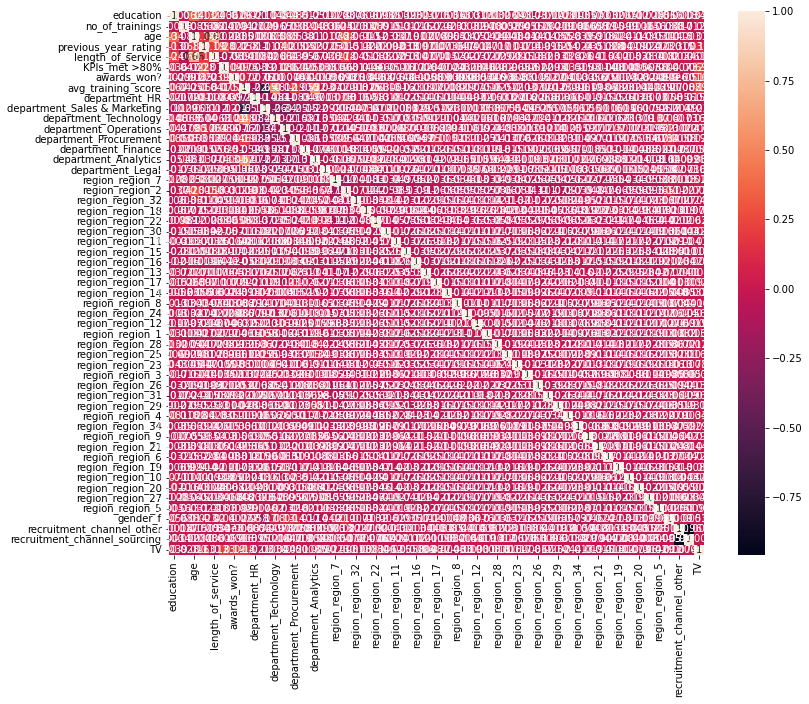

In [17]:
hr_corr = pearson_corr(xtra,ytra)

In [18]:
print(hr_corr.TV[hr_corr["TV"]>0.1])
print(hr_corr.TV[hr_corr["TV"]<-0.1])

previous_year_rating    0.126691
KPIs_met >80%           0.225614
awards_won?             0.192871
avg_training_score      0.180511
TV                      1.000000
Name: TV, dtype: float64
Series([], Name: TV, dtype: float64)


In [19]:
num = ["no_of_trainings","age","length_of_service","avg_training_score"]
xtr = xtra[xtra.columns[~xtra.columns.isin(num)]]
xte = xtes[xtes.columns[~xtes.columns.isin(num)]]

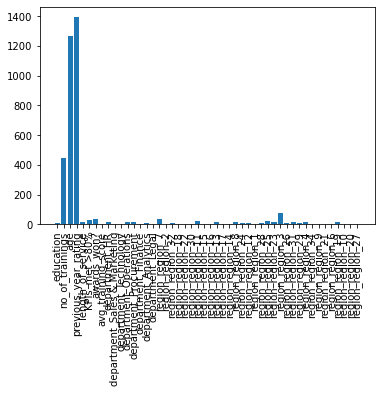

3577.406680410906


Index(['education', 'previous_year_rating', 'KPIs_met >80%', 'awards_won?',
       'department_HR', 'department_Sales & Marketing',
       'department_Technology', 'department_Procurement', 'department_Legal',
       'region_region_7', 'region_region_32', 'region_region_22',
       'region_region_17', 'region_region_24', 'region_region_28',
       'region_region_25', 'region_region_23', 'region_region_26',
       'region_region_31', 'region_region_29', 'region_region_4',
       'region_region_9', 'region_region_6', 'region_region_5'],
      dtype='object')

In [20]:
cs = chi_sq(xtr,xte,ytra)
csls = []
for i in range(len(cs.scores_)):
    if cs.scores_[i] > 10:
        csls.append(i)
xtr.iloc[:,csls].columns

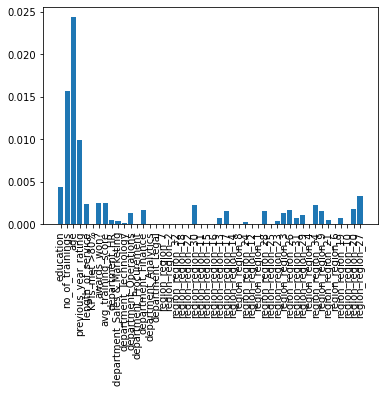

0.08788184811936217


Index(['education', 'previous_year_rating', 'KPIs_met >80%', 'awards_won?',
       'department_HR', 'department_Technology', 'department_Operations',
       'department_Legal', 'region_region_2', 'region_region_13',
       'region_region_12', 'region_region_26', 'region_region_4',
       'region_region_34', 'region_region_21', 'region_region_19',
       'region_region_10', 'recruitment_channel_other',
       'recruitment_channel_sourcing'],
      dtype='object')

In [21]:
mi = mi_select(xtr,xte,ytra)
mils = []
for i in range(len(mi.scores_)):
    if mi.scores_[i] > 0.001:
        mils.append(i)
xtr.iloc[:,mils].columns

### 1.4 Export the data

In [22]:
def export(xtra,xtes,ytra,ytes,path, tv):
    xtra[tv] = ytra
    xtes[tv] = ytes
    df = pd.concat([xtra,xtes])
    df.to_csv(path, index = False, header = True)
    return df.shape

In [23]:
# exported cols
exp = list(xtr.columns[list(set(csls) & set(mils))]) + num
traint = xtra.loc[:,exp]
testt = xtes.loc[:,exp]

In [24]:
export(traint,testt,ytra,ytes,"cleaned_hr.csv","is_promoted")

(54808, 14)

## 2. Airbnb

### 2.1 Load and Explore the data

In [25]:
df = pd.read_csv(".\data\listings.csv")
print(df.shape)
df.head()

(7907, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [26]:
df.isnull().sum()

id                                   0
name                                 2
host_id                              0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       2758
reviews_per_month                 2758
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [27]:
df[df["last_review"].isnull()].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
18,355955,Double room in an Authentic Peranakan Shophouse,1759905,Aresha,Central Region,Geylang,1.31420,103.90232,Private room,81,90,0,NaN,NaN,1,173
23,481789,Master Bedroom in Newly Built Flat,2386154,Susan,East Region,Tampines,1.34816,103.93238,Private room,37,180,0,NaN,NaN,1,365
26,642660,BEST CITY LIVING WITH GA RESIDENCE,3212572,Roger,Central Region,Rochor,1.30109,103.85234,Private room,167,180,0,NaN,NaN,1,365
28,719944,HDB housing in prime area near town,3648224,Audrey,Central Region,Queenstown,1.30901,103.79639,Shared room,208,1,0,NaN,NaN,1,0
29,733863,Homestay at Serangoon,3824517,Shirlnet,North-East Region,Serangoon,1.36743,103.87288,Private room,26,180,0,NaN,NaN,1,365


In [28]:
df[df["reviews_per_month"].isnull()].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
18,355955,Double room in an Authentic Peranakan Shophouse,1759905,Aresha,Central Region,Geylang,1.31420,103.90232,Private room,81,90,0,NaN,NaN,1,173
23,481789,Master Bedroom in Newly Built Flat,2386154,Susan,East Region,Tampines,1.34816,103.93238,Private room,37,180,0,NaN,NaN,1,365
26,642660,BEST CITY LIVING WITH GA RESIDENCE,3212572,Roger,Central Region,Rochor,1.30109,103.85234,Private room,167,180,0,NaN,NaN,1,365
28,719944,HDB housing in prime area near town,3648224,Audrey,Central Region,Queenstown,1.30901,103.79639,Shared room,208,1,0,NaN,NaN,1,0
29,733863,Homestay at Serangoon,3824517,Shirlnet,North-East Region,Serangoon,1.36743,103.87288,Private room,26,180,0,NaN,NaN,1,365


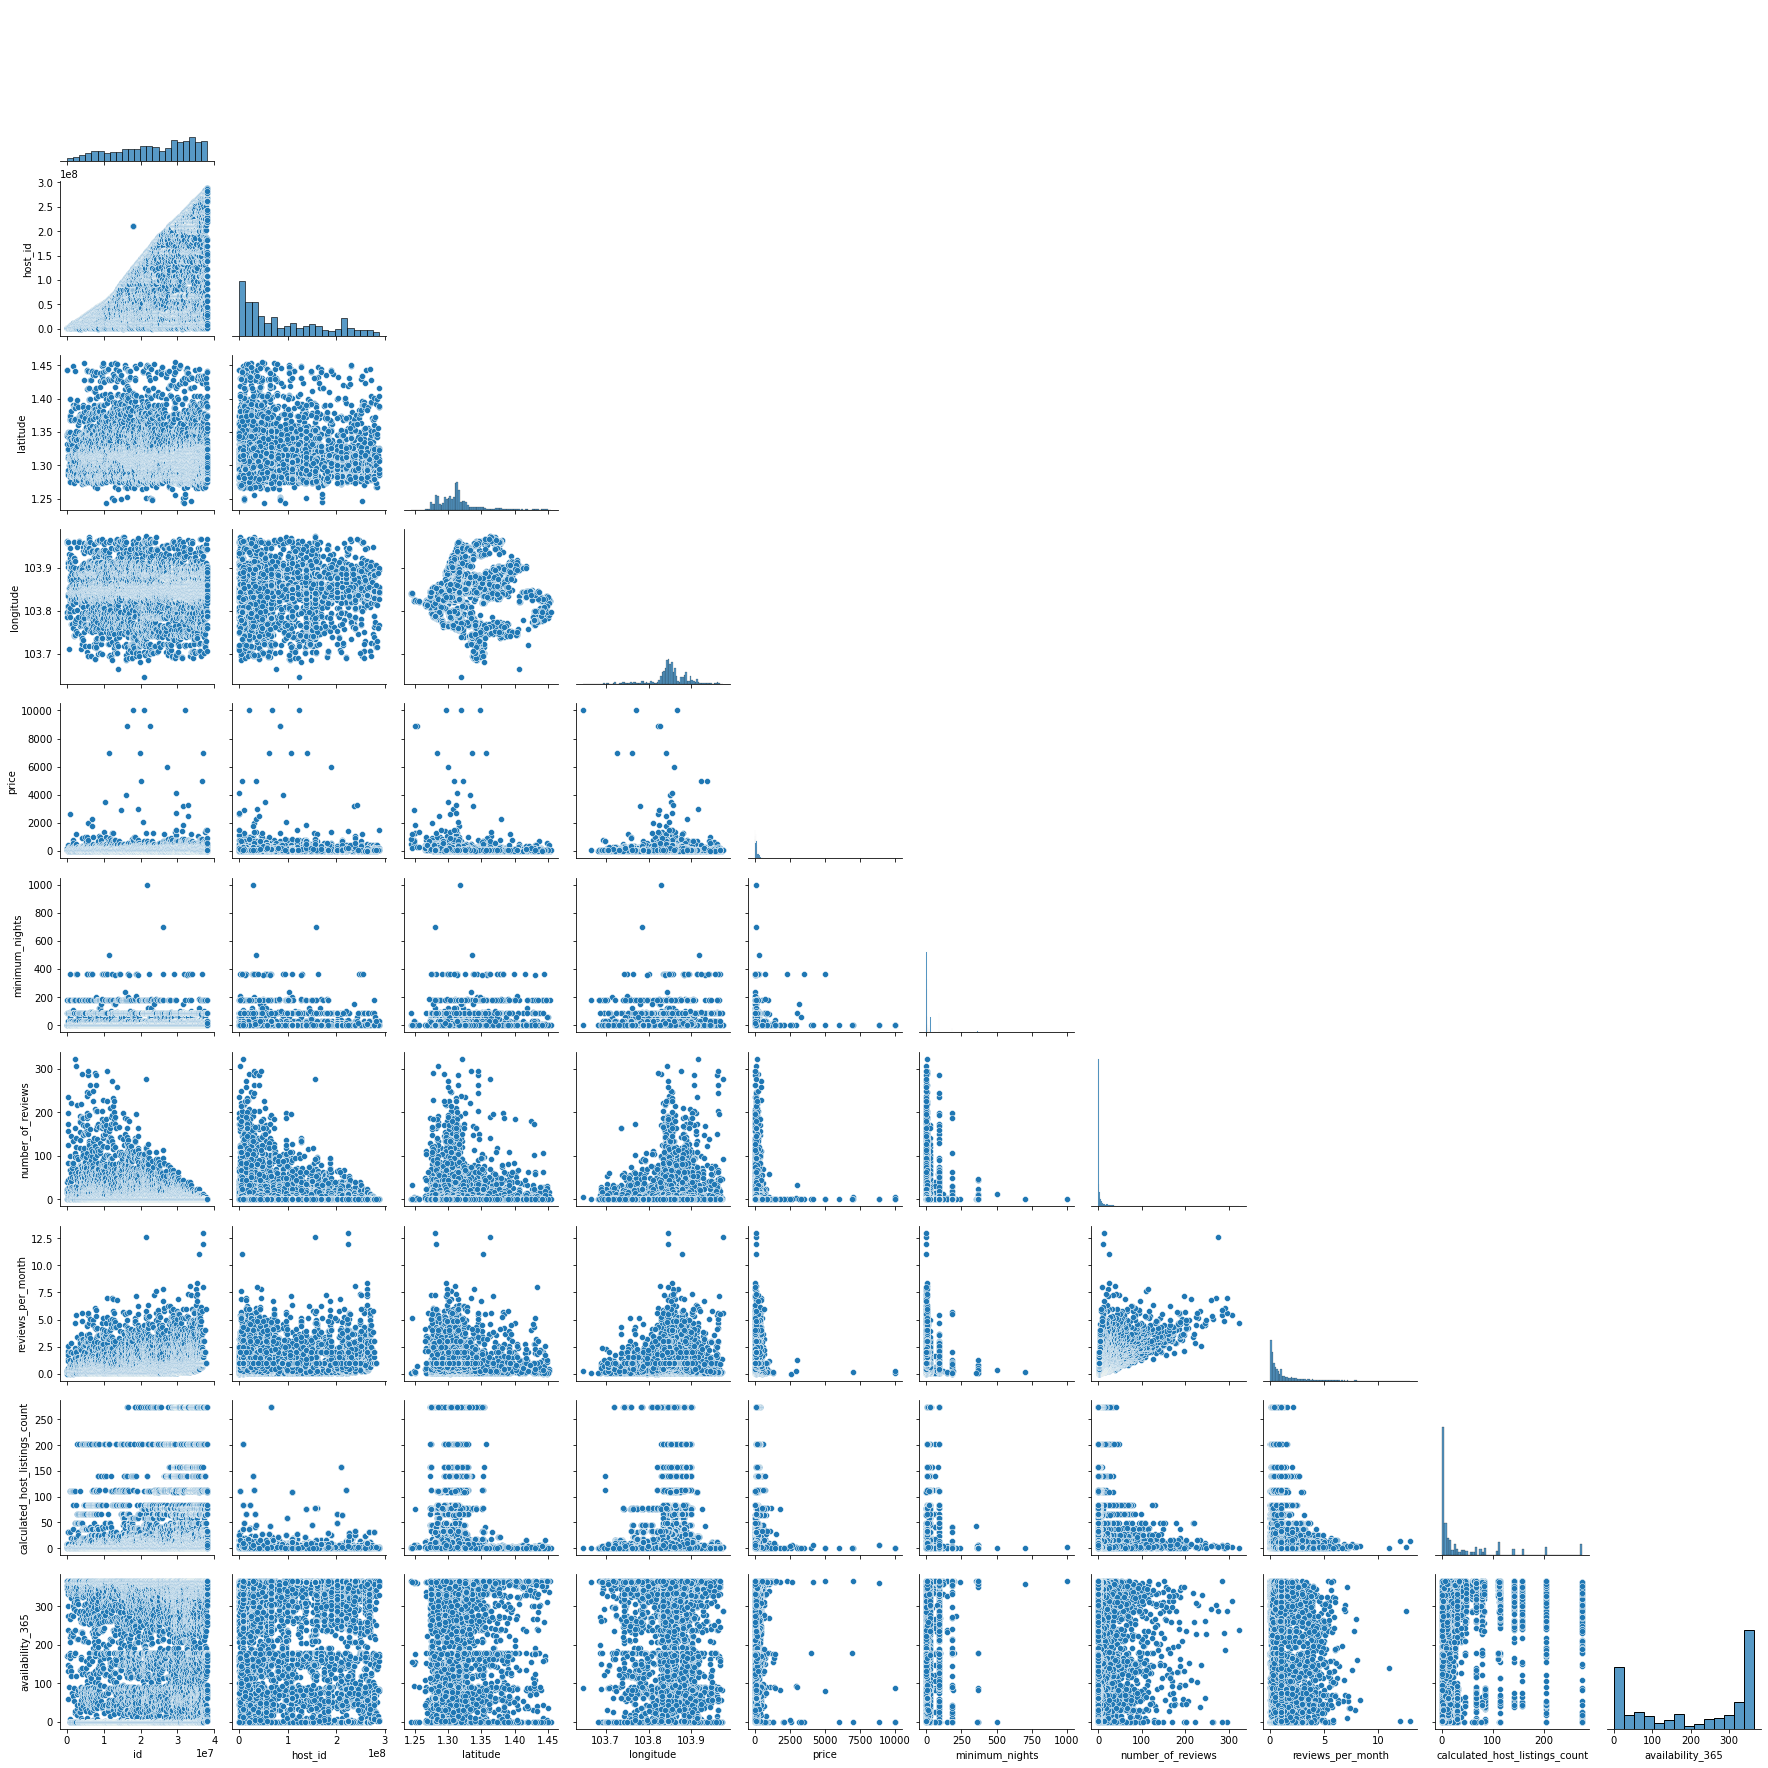

In [29]:
sns.pairplot(df, corner = True)
plt.show()

### 2.2 Cleanse and Transform the data

In [30]:
# drop the identifying features, such as Name, id, host_id and host_name
df.drop(columns =["id","name","host_id"
                 ,"host_name"], inplace =True)

In [31]:
df["last_review"].fillna(0,inplace = True)
df["reviews_per_month"].fillna(0,inplace = True)

In [32]:
def tts(df,target = "price"):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop(target, axis=1), df[target], test_size=0.3, random_state = 1)
    return X_train, X_test, y_train, y_test

In [33]:
def find_boundaries(df, variable, distance):

    ''' used for acquiring IQR and outliers ;
    distance passed as an argument, gives us the option to
    estimate 1.5 times or 3 times the IQR to calculate
    the boundaries.'''
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

find_boundaries(df,"price",1.5)

(400.0, -136.0)

In [34]:
len(df[df["price"]>1000])

45

In [35]:
df = df[df["price"]<= 400]
df.shape

(7583, 12)

In [36]:
# type cast date to retrieve the number of days since last review
# considering the metadata of the airbnb dataset
df["last_review"] = pd.to_datetime(df["last_review"])

In [37]:
df["days_since_last_review"] = (pd.Timestamp("2022-11-10") - df['last_review']).dt.days
# those with no last_review would have -1days since last review instead, to reflect that it has never recieved a review
df["days_since_last_review"].replace(to_replace = 19306, value = -1, inplace = True)

In [38]:
df.drop(columns = "last_review",inplace = True)

In [39]:
xtra,xtes,ytra,ytes = tts(df)

In [40]:
from feature_engine.encoding import MeanEncoder
enc = MeanEncoder(variables=None)
enc.fit(xtra,ytra)
xtra  = enc.transform(xtra)
xtes = enc.transform(xtes)

C:\Users\Kayen\anaconda3\lib\site-packages\feature_engine\encoding\base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) neighbourhood.
  warnings.warn(


In [41]:
def standardscale(X_train , X_test):
    from sklearn.preprocessing import StandardScaler
    # set up the scaler
    scaler = StandardScaler()

    # fit the scaler to the train set, it will learn the parameters
    scaler.fit(X_train)

    # transform train and test sets
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    return X_train_scaled , X_test_scaled

In [42]:
xtra, xtes = standardscale(xtra,xtes)

### 2.3 Correlation Analysis

In [43]:
# sns heatmap
def pearson_corr(xp,yp):
    #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    xp["TV"] = yp
    cor = xp.corr()
    sns.heatmap(cor, annot=True)
    plt.show()
    xp.drop(columns ="TV",inplace = True)
    return cor
# stats analysis
def ols_eval(y_train, X_train):
    lm2 = sm.OLS(y_train, X_train).fit()
    return lm2.summary()

def rfe_eval(x,y):
    highest = 0
    model = LinearRegression()
    for i in range(1,len(x.columns) + 1):
        m, s = rfe(model,x,y,i)
        if s > highest:
            highest = s
            hm = m
    temp = pd.Series(hm.support_, index = x.columns)
    selected_features_rfe = temp[temp==True].index
    print(len(selected_features_rfe))
    print(selected_features_rfe)
    print(x.columns.drop(selected_features_rfe))
        
def rfe(model,x,y,i):
    rfe = RFE(model,i)
    Xrfe = rfe.fit_transform(x,y)
    model.fit(Xrfe, y)
    score = model.score(Xrfe,y)
    return [rfe,score]
# lasso model
def lasso_eval(X,y):
    reg = LassoCV()
    reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" %reg.score(X,y))
    coef = pd.Series(reg.coef_, index = X.columns)
    imp_coef = coef.sort_values()
    matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    return imp_coef
    
# nn

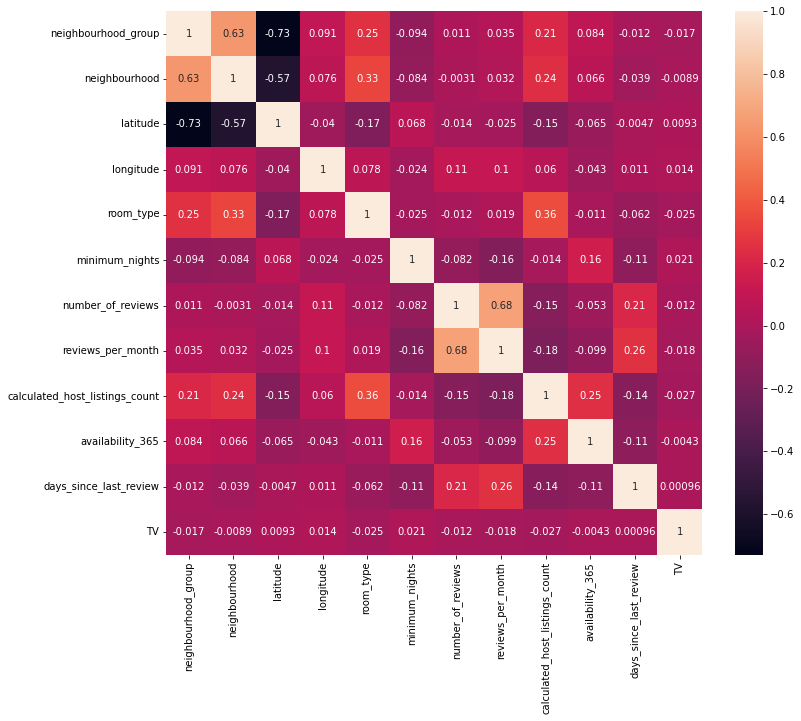

In [44]:
r_corr = pearson_corr(xtra,ytra)

In [45]:
print(r_corr.TV[r_corr["TV"]>0.1])
print(r_corr.TV[r_corr["TV"]<-0.1])

TV    1.0
Name: TV, dtype: float64
Series([], Name: TV, dtype: float64)


In [46]:
ols_eval(list(ytra),xtra)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.130
Model:                            OLS   Adj. R-squared (uncentered):              0.128
Method:                 Least Squares   F-statistic:                              71.67
Date:                Sat, 17 Dec 2022   Prob (F-statistic):                   1.26e-150
Time:                        23:12:32   Log-Likelihood:                         -34108.
No. Observations:                5308   AIC:                                  6.824e+04
Df Residuals:                    5297   BIC:                                  6.831e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
neighbourhood_group               -6.5107      3.278     -1.986      0.047     -12.938      -0.084
neighbourhood                     14.3139      2.799      5.113      0.000       8.826      19.802
latitude                          -3.7491      3.077     -1.218      0.223      -9.782       2.283
longitude                         -1.7295      2.087     -0.829      0.407      -5.822       2.363
room_type                         52.6359      2.312     22.763      0.000      48.103      57.169
minimum_nights                    -8.9379      2.127     -4.203      0.000     -13.107      -4.769
number_of_reviews                 -5.2478      2.800     -1.874      0.061     -10.738       0.242
reviews_per_month                  2.8482      2.879      0.989      0.322      -2.795       8.491
calculated_host_listings_count    -6.9182      2.359     -2.933      0.003     -11.543      -2.294
availability_365                  11.5847      2.178      5.319      0.000       7.315      15.854
days_since_last_review            -3.9154      2.150     -1.821      0.069      -8.130       0.299
==============================================================================
Omnibus:                     1099.089   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2322.428
Skew:                           1.207   Prob(JB):                         0.00
Kurtosis:                       5.162   Cond. No.                         3.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
rfe_eval(xtra,ytra)

11
Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'days_since_last_review'],
      dtype='object')
Index([], dtype='object')


C:\Users\Kayen\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Kayen\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Kayen\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Kayen\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_featur

Best alpha using built-in LassoCV: 0.054228
Best score using built-in LassoCV: 0.447246


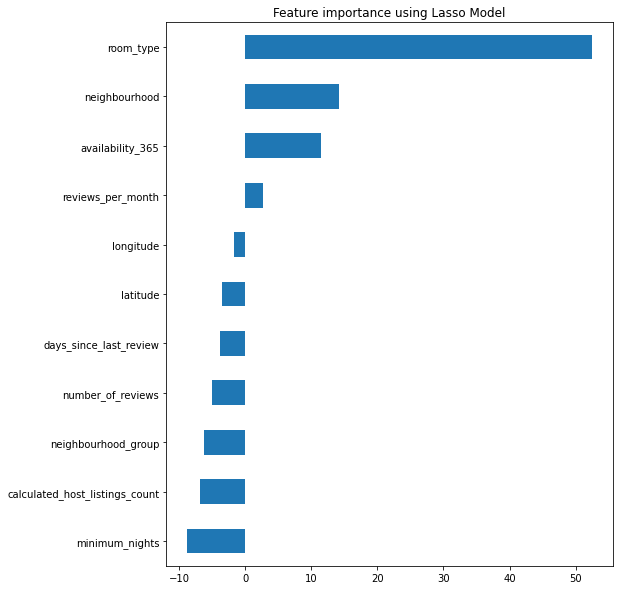

In [48]:
coeff = lasso_eval(xtra,ytra)

### 2.4 Export the data

In [49]:
traint = xtra
testt = xtes
export(traint,testt,ytra,ytes,"cleaned_listings.csv","price")

(7583, 12)